# Modeling

Some code adapted from: [A Data Science Framework: To Achieve 99% Accuracy](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy)

In [1]:
# Core Packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

# Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, classification_report, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

import os
os.chdir("/Users/erikgregorywebb/Documents/Python/nba-prediction/Modeling/Data")

In [2]:
def scale_data(train, test):
    # Scaler
    scaler = StandardScaler()
    
    # Train
    target_train = train['Win']
    train = train.drop(['Win'], axis = 1)
    scaler.fit(train)
    scaled_train = scaler.transform(train)
    
    # Test
    target_test = test['Win']
    test = test.drop(['Win'], axis = 1)
    scaled_test = scaler.transform(test)
    
    # Column Names
    col_names = train.columns
    
    return scaled_train, scaled_test, target_train, target_test, col_names

def model_data(scaled_train, scaled_test, target_train, target_test):
    # Split dataset in cross-validation with this splitter class; run model 10 times with 80/20 split
    cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 0) 

    # Create table to compare MLA metrics
    MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean','MLA Time']
    MLA_compare = pd.DataFrame(columns = MLA_columns)
    
    row = 0
    for alg in MLA:    
        # Set name and parameters
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row, 'MLA Name'] = MLA_name
        MLA_compare.loc[row, 'MLA Parameters'] = str(alg.get_params())
    
        # Score model with cross validation:
        cv_results = model_selection.cross_validate(alg, scaled_train, target_train, cv  = cv_split)

        MLA_compare.loc[row, 'MLA Time'] = cv_results['fit_time'].mean()
        MLA_compare.loc[row, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
        MLA_compare.loc[row, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()       
        row = row + 1
        
    MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
    MLA_compare = MLA_compare.drop(['MLA Parameters'], axis = 1) # Drop for the purpose of presenting
    return MLA_compare

def plot_data(dataframe, column):
    #plt.figure(figsize=(10,10))
    dataframe.sort_values(by = [column], ascending = False, inplace = True)
    sns.barplot(x=column, y = 'MLA Name', data = dataframe, color = 'b')
    plt.title('Mean Test Accuracy by Algorithm \n')
    plt.xlabel(column)
    plt.ylabel('Algorithm')

In [3]:
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(), ensemble.BaggingClassifier(), ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(), ensemble.RandomForestClassifier(),
    
    # Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(),
    
    # GLM
    linear_model.LogisticRegressionCV(), linear_model.PassiveAggressiveClassifier(), linear_model.RidgeClassifierCV(), 
    linear_model.SGDClassifier(), linear_model.Perceptron(),
    
    # Navies Bayes
    naive_bayes.BernoulliNB(), naive_bayes.GaussianNB(),
    
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    # SVM
    svm.SVC(probability=True), svm.NuSVC(probability=True), svm.LinearSVC(),
    
    # Trees    
    tree.DecisionTreeClassifier(), tree.ExtraTreeClassifier(),
    
    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(), discriminant_analysis.QuadraticDiscriminantAnalysis(),

    # Xgboost
    XGBClassifier()]

### 4 Factors

https://www.nbastuffer.com/analytics101/four-factors/
- Shooting the ball:  Effective Field Goal Percentage
- Taking care of the ball: Turnover Rate
- Offensive rebounding: Offensive Rebounding Percentage
- Getting to the foul line: Free Throw Rate

In [4]:
# Prepare the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = train[['Win','avg_team_eFG%', 'avg_team_TOV%', 'avg_team_ORB%', 'avg_team_FTr', 'avg_opp_eFG%', 'avg_opp_TOV%', 'avg_opp_ORB%', 'avg_opp_FTr']]
test = test[['Win','avg_team_eFG%', 'avg_team_TOV%', 'avg_team_ORB%', 'avg_team_FTr', 'avg_opp_eFG%', 'avg_opp_TOV%', 'avg_opp_ORB%', 'avg_opp_FTr']]

In [5]:
scaled_train, scaled_test, target_train, target_test, col_names = scale_data(train, test)
ff = model_data(scaled_train, scaled_test, target_train, target_test)
ff.head()

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time
18,LinearDiscriminantAnalysis,0.576213,0.566334,0.004602
15,LinearSVC,0.576213,0.566334,0.267726
7,RidgeClassifierCV,0.576213,0.566334,0.00594158
5,LogisticRegressionCV,0.576641,0.565288,0.101892
11,GaussianNB,0.576546,0.563481,0.00193853


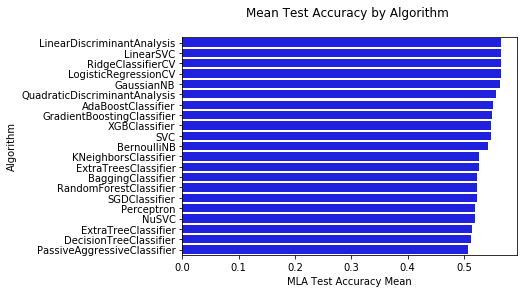

In [6]:
plot_data(ff, 'MLA Test Accuracy Mean')
plt.savefig("ff.png", dpi=300)

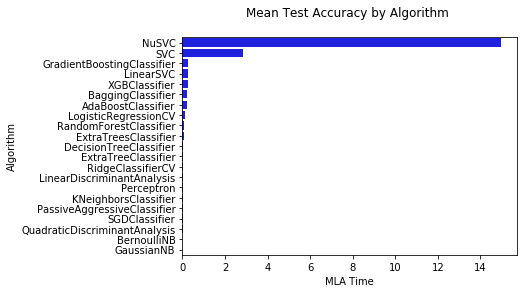

In [7]:
plot_data(ff, 'MLA Time')

### All variables (excluding rank)

In [8]:
# Prepare the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = train.drop(['Team', 'Opponent', 'Team-Score', 'Location', 'Opponent-Score', 'Date', 'Time', 'Season', 'Rank'], axis = 1)
test = test.drop(['Team', 'Opponent', 'Team-Score', 'Location', 'Opponent-Score', 'Date', 'Time', 'Season', 'Rank'], axis = 1)

In [9]:
scaled_train, scaled_test, target_train, target_test, col_names = scale_data(train, test)
aver = model_data(scaled_train, scaled_test, target_train, target_test)
aver.head()

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time
5,LogisticRegressionCV,0.62745,0.61379,1.14824
7,RidgeClassifierCV,0.625262,0.612934,0.0305009
15,LinearSVC,0.62588,0.608845,1.42277
18,LinearDiscriminantAnalysis,0.625642,0.608559,0.0203569
20,XGBClassifier,0.736061,0.598003,1.42655


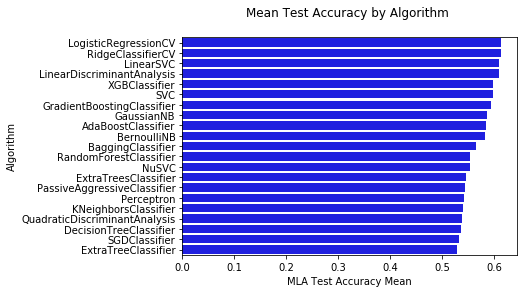

In [10]:
plot_data(aver, 'MLA Test Accuracy Mean')

### All Variables (Including Rank)

In [11]:
# Prepare the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = train.drop(['Team', 'Opponent', 'Team-Score', 'Location', 'Opponent-Score', 'Date', 'Time', 'Season'], axis = 1)
test = test.drop(['Team', 'Opponent', 'Team-Score', 'Location', 'Opponent-Score', 'Date', 'Time', 'Season'], axis = 1)

In [12]:
scaled_train, scaled_test, target_train, target_test, col_names = scale_data(train, test)
av = model_data(scaled_train, scaled_test, target_train, target_test)
av.head()

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time
5,LogisticRegressionCV,0.636727,0.629291,0.898152
7,RidgeClassifierCV,0.637536,0.628816,0.0313344
15,LinearSVC,0.638011,0.627104,1.34337
18,LinearDiscriminantAnalysis,0.638582,0.625012,0.0191939
3,GradientBoostingClassifier,0.745576,0.615121,1.1882


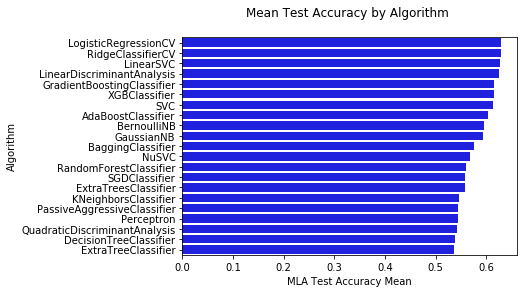

In [13]:
plot_data(av, 'MLA Test Accuracy Mean')

### Model Tuning

In [14]:
# Fit Model
param_dist = {'Cs': [1, 10, 100], "solver": ['newton-cg', 'lbfgs', 'liblinear']}
model = linear_model.LogisticRegressionCV()
alg = GridSearchCV(model, param_grid = param_dist, scoring='f1')
alg.fit(scaled_train, target_train)

# Make Predictions
alg_train_predictions = alg.predict(scaled_train)
alg_test_predictions = alg.predict(scaled_test)
print("Best Params: {}".format(alg.best_params_))

Best Params: {'Cs': 10, 'solver': 'newton-cg'}


In [15]:
# Training Accuracy Score
accuracy_score(target_train, alg_train_predictions)

0.6364155251141552

In [16]:
# Test Accuracy Score
accuracy_score(target_test, alg_test_predictions)

0.6159600997506235

### Feature Importance

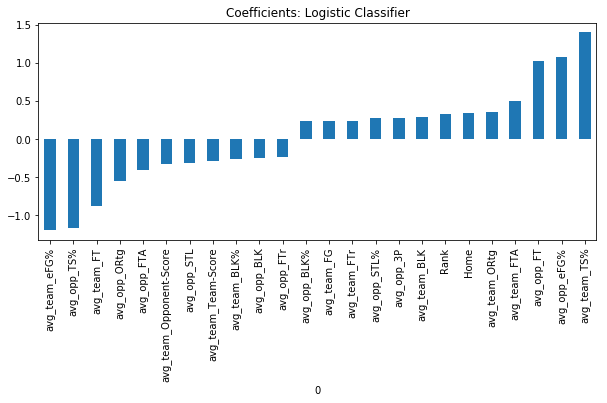

In [17]:
# Create a dataframe with coefficient values
coefs = pd.DataFrame(sorted(list(zip(col_names, alg.best_estimator_.coef_[0])), key=lambda x: x[1]))
coefs.index = coefs[0]
coefs = coefs.drop([0], axis = 1)

# Filter to keep most important variables
val = coefs[1].quantile(.8)
coefs = coefs[(coefs[1] > val) | (coefs[1] < -val)]

# Create a bar chart with the coefficients
plt.figure(figsize=(10,10))
plt.rcParams['figure.figsize'] = (10, 4)
coefs.plot(kind = "bar",  title = "Coefficients: Logistic Classifier", legend = False)

### Predictions

In [18]:
# Make Predictions
alg_test_predictions = alg.predict(scaled_test)
alg_test_prob_predictions = alg.predict_proba(scaled_test)

# Create DataFrame including Predictions
test = pd.read_csv("test.csv")
test['Pred_Win'] = list(alg_test_predictions)
test['Pred_Win_Prob'] = list(alg_test_prob_predictions[:,1])
prediction_df = test[['Team', 'Opponent', 'Date', 'Win', 'Pred_Win', 'Pred_Win_Prob']]

In [19]:
prediction_df.head()

,Team,Opponent,Date,Win,Pred_Win,Pred_Win_Prob
0,San Antonio Spurs,Sacramento Kings,2016-10-27,1,0,0.489434
1,Sacramento Kings,San Antonio Spurs,2016-10-27,0,0,0.484815
2,Charlotte Hornets,Miami Heat,2016-10-28,1,0,0.429058
3,Golden State Warriors,New Orleans Pelicans,2016-10-28,1,1,0.501405
4,Cleveland Cavaliers,Toronto Raptors,2016-10-28,1,1,0.536855


Text(0.5,0,'Predicted Win Probability')

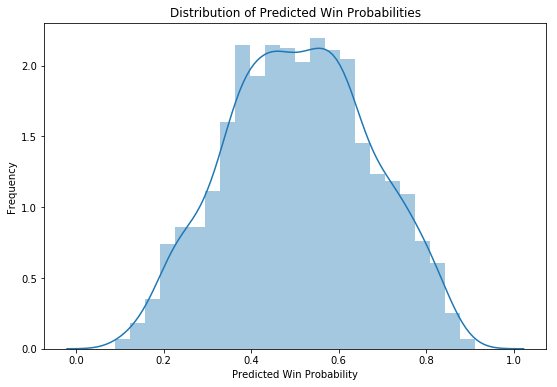

In [20]:
# Distribution of Predicted Win Probabilities
plt.figure(figsize=(9,6))
sns.distplot(test['Pred_Win_Prob'])
plt.title('Distribution of Predicted Win Probabilities')
plt.ylabel('Frequency')
plt.xlabel('Predicted Win Probability')